# Nested Sampling with JAX-bandflux

This notebook demonstrates how to run the nested sampling procedure for supernovae SALT model fitting using the JAX-bandflux package (as implemented in `ns.py`). We will install the package, load the data, set up and run the nested sampling algorithm, and finally produce a corner plot of the posterior samples.

For more examples and the complete codebase, visit the [JAX-bandflux GitHub repository](https://github.com/samleeney/JAX-bandflux). The academic paper associated with this work can be found [here](https://github.com/samleeney/JAX-bandflux/blob/71ca8d1b3b273147e1e9bf60a9ef11a806363b80/paper.bib).

In [ ]:
# Install JAX-bandflux and its dependencies
!pip install jax-bandflux

# Install BlackjaxNS and distrax
!pip install git+https://github.com/handley-lab/blackjax@proposal
!pip install git+https://github.com/google-deepmind/distrax

# Additional dependencies
!pip install jax jaxlib anesthetic matplotlib tqdm

## Importing Libraries and Loading Data

In this section, we import the required libraries and load the supernova light curve data using the function `load_and_process_data`. This function will also register the required bandpasses, process the data, and prepare it for modelling.

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os

import blackjax
from blackjax.ns.utils import log_weights
from jax_supernovae.salt3 import optimized_salt3_multiband_flux
from jax_supernovae.data import load_and_process_data
from jax_supernovae.bandpasses import register_bandpass, get_bandpass, register_all_bandpasses
from jax_supernovae.utils import save_chains_dead_birth
from anesthetic import read_chains, make_2d_axes

# Set flag to use fixed redshift
fix_z = True

# Load and process the data (ensure your data files are in the 'data' directory)
times, fluxes, fluxerrs, zps, band_indices, bridges, fixed_z = load_and_process_data('19dwz', data_dir='data', fix_z=fix_z)

print('Data loaded:')
print('Observation times shape:', times.shape)
print('Flux measurements shape:', fluxes.shape)

## Setting Up the Nested Sampling Algorithm

Here we define the necessary functions for nested sampling. These include the log prior and log likelihood functions, which will be utilised by the sampling algorithm from Blackjax. The parameters being fitted are `t0`, `x0` (expressed in log scale), `x1`, `c` and optionally `log_sigma`. Prior bounds and distributions are defined accordingly.

### Nested sampling settings
On a GPU, you might consider setting 'n_delete' to a value close to n_live/2, e.g.,
`NS_SETTINGS['n_delete'] = NS_SETTINGS['n_live'] // 2`. This change can substantially speedup the nested sampling algorithm.

In [ ]:
# Nested sampling settings
NS_SETTINGS = {
    'num_delete': 20,
    'n_live': 200,
    'num_mcmc_steps_multiplier': 5
}

### Setup prior bounds and distributions
In this section, we define the prior bounds and distributions for our SALT3 model parameters. The priors are uniform distributions over physically meaningful ranges for each parameter. For fixed redshift cases, we fit for `t0` (time of peak brightness), `x0` (overall amplitude), `x1` (light curve stretch), and `c` (colour). When redshift is not fixed, we also fit for `z` (redshift).

In [43]:
import os
import distrax
import blackjax

# Define prior bounds for parameters
PRIOR_BOUNDS = {
    't0': {'min': 58000.0, 'max': 59000.0},
    'x0': {'min': -5.0, 'max': -2.6},
    'x1': {'min': -4.0, 'max': 4.0},
    'c': {'min': -0.3, 'max': 0.3},
    'log_sigma': {'min': -3.0, 'max': 1.0}
}

# Set whether to fit sigma (extra free parameter)
fit_sigma = False

if fix_z:
    param_bounds = {
        't0': (PRIOR_BOUNDS['t0']['min'], PRIOR_BOUNDS['t0']['max']),
        'x0': (PRIOR_BOUNDS['x0']['min'], PRIOR_BOUNDS['x0']['max']),
        'x1': (PRIOR_BOUNDS['x1']['min'], PRIOR_BOUNDS['x1']['max']),
        'c': (PRIOR_BOUNDS['c']['min'], PRIOR_BOUNDS['c']['max'])
    }
    if fit_sigma:
        param_bounds['log_sigma'] = (PRIOR_BOUNDS['log_sigma']['min'], PRIOR_BOUNDS['log_sigma']['max'])
    prior_dists = {
        't0': distrax.Uniform(low=param_bounds['t0'][0], high=param_bounds['t0'][1]),
        'x0': distrax.Uniform(low=param_bounds['x0'][0], high=param_bounds['x0'][1]),
        'x1': distrax.Uniform(low=param_bounds['x1'][0], high=param_bounds['x1'][1]),
        'c': distrax.Uniform(low=param_bounds['c'][0], high=param_bounds['c'][1])
    }
    if fit_sigma:
        prior_dists['log_sigma'] = distrax.Uniform(low=param_bounds['log_sigma'][0], high=param_bounds['log_sigma'][1])
else:
    param_bounds = {
        'z': (0.001, 0.2),
        't0': (PRIOR_BOUNDS['t0']['min'], PRIOR_BOUNDS['t0']['max']),
        'x0': (PRIOR_BOUNDS['x0']['min'], PRIOR_BOUNDS['x0']['max']),
        'x1': (PRIOR_BOUNDS['x1']['min'], PRIOR_BOUNDS['x1']['max']),
        'c': (PRIOR_BOUNDS['c']['min'], PRIOR_BOUNDS['c']['max'])
    }
    if fit_sigma:
        param_bounds['log_sigma'] = (PRIOR_BOUNDS['log_sigma']['min'], PRIOR_BOUNDS['log_sigma']['max'])
    prior_dists = {
        'z': distrax.Uniform(low=param_bounds['z'][0], high=param_bounds['z'][1]),
        't0': distrax.Uniform(low=param_bounds['t0'][0], high=param_bounds['t0'][1]),
        'x0': distrax.Uniform(low=param_bounds['x0'][0], high=param_bounds['x0'][1]),
        'x1': distrax.Uniform(low=param_bounds['x1'][0], high=param_bounds['x1'][1]),
        'c': distrax.Uniform(low=param_bounds['c'][0], high=param_bounds['c'][1])
    }
    if fit_sigma:
        prior_dists['log_sigma'] = distrax.Uniform(low=param_bounds['log_sigma'][0], high=param_bounds['log_sigma'][1])

@jax.jit
def logprior(params):
    if fix_z:
        if fit_sigma:
            logp = (prior_dists['t0'].log_prob(params[0]) +
                    prior_dists['x0'].log_prob(params[1]) +
                    prior_dists['x1'].log_prob(params[2]) +
                    prior_dists['c'].log_prob(params[3]) +
                    prior_dists['log_sigma'].log_prob(params[4]))
        else:
            logp = (prior_dists['t0'].log_prob(params[0]) +
                    prior_dists['x0'].log_prob(params[1]) +
                    prior_dists['x1'].log_prob(params[2]) +
                    prior_dists['c'].log_prob(params[3]))
    else:
        if fit_sigma:
            logp = (prior_dists['z'].log_prob(params[0]) +
                    prior_dists['t0'].log_prob(params[1]) +
                    prior_dists['x0'].log_prob(params[2]) +
                    prior_dists['x1'].log_prob(params[3]) +
                    prior_dists['c'].log_prob(params[4]) +
                    prior_dists['log_sigma'].log_prob(params[5]))
        else:
            logp = (prior_dists['z'].log_prob(params[0]) +
                    prior_dists['t0'].log_prob(params[1]) +
                    prior_dists['x0'].log_prob(params[2]) +
                    prior_dists['x1'].log_prob(params[3]) +
                    prior_dists['c'].log_prob(params[4]))
    return logp
# Define the log likelihood functions
@jax.jit
def compute_single_loglikelihood(params):
    if fix_z:
        if fit_sigma:
            t0, log_x0, x1, c, log_sigma = params
            sigma = 10 ** log_sigma
        else:
            t0, log_x0, x1, c = params
            sigma = 1.0
        z = fixed_z[0]
    else:
        if fit_sigma:
            z, t0, log_x0, x1, c, log_sigma = params
            sigma = 10 ** log_sigma
        else:
            z, t0, log_x0, x1, c = params
            sigma = 1.0
    x0 = 10 ** log_x0
    param_dict = {'z': z, 't0': t0, 'x0': x0, 'x1': x1, 'c': c}
    model_fluxes = optimized_salt3_multiband_flux(times, bridges, param_dict, zps=zps, zpsys='ab')
    model_fluxes = model_fluxes[jnp.arange(len(times)), band_indices]
    eff_fluxerrs = sigma * fluxerrs
    chi2 = jnp.sum(((fluxes - model_fluxes) / eff_fluxerrs) ** 2)
    log_likelihood = -0.5 * (chi2 + jnp.sum(jnp.log(2 * jnp.pi * eff_fluxerrs ** 2)))
    return log_likelihood

def sample_from_priors(rng_key, n_samples):
    if fix_z:
        if fit_sigma:
            keys = jax.random.split(rng_key, 5)
            return jnp.column_stack([
                prior_dists['t0'].sample(seed=keys[0], sample_shape=(n_samples,)),
                prior_dists['x0'].sample(seed=keys[1], sample_shape=(n_samples,)),
                prior_dists['x1'].sample(seed=keys[2], sample_shape=(n_samples,)),
                prior_dists['c'].sample(seed=keys[3], sample_shape=(n_samples,)),
                prior_dists['log_sigma'].sample(seed=keys[4], sample_shape=(n_samples,))
            ])
        else:
            keys = jax.random.split(rng_key, 4)
            return jnp.column_stack([
                prior_dists['t0'].sample(seed=keys[0], sample_shape=(n_samples,)),
                prior_dists['x0'].sample(seed=keys[1], sample_shape=(n_samples,)),
                prior_dists['x1'].sample(seed=keys[2], sample_shape=(n_samples,)),
                prior_dists['c'].sample(seed=keys[3], sample_shape=(n_samples,))
            ])
    else:
        if fit_sigma:
            keys = jax.random.split(rng_key, 6)
            return jnp.column_stack([
                prior_dists['z'].sample(seed=keys[0], sample_shape=(n_samples,)),
                prior_dists['t0'].sample(seed=keys[1], sample_shape=(n_samples,)),
                prior_dists['x0'].sample(seed=keys[2], sample_shape=(n_samples,)),
                prior_dists['x1'].sample(seed=keys[3], sample_shape=(n_samples,)),
                prior_dists['c'].sample(seed=keys[4], sample_shape=(n_samples,)),
                prior_dists['log_sigma'].sample(seed=keys[5], sample_shape=(n_samples,))
            ])
        else:
            keys = jax.random.split(rng_key, 5)
            return jnp.column_stack([
                prior_dists['z'].sample(seed=keys[0], sample_shape=(n_samples,)),
                prior_dists['t0'].sample(seed=keys[1], sample_shape=(n_samples,)),
                prior_dists['x0'].sample(seed=keys[2], sample_shape=(n_samples,)),
                prior_dists['x1'].sample(seed=keys[3], sample_shape=(n_samples,)),
                prior_dists['c'].sample(seed=keys[4], sample_shape=(n_samples,))
            ])

if fix_z:
    n_params_total = 4
else:
    n_params_total = 5
if fit_sigma:
    n_params_total += 1

### Initialise the nested sampling algorithm

In [ ]:
num_mcmc_steps = n_params_total * NS_SETTINGS['num_mcmc_steps_multiplier']

# Initialise the nested sampling algorithm using Blackjax
print("Setting up nested sampling algorithm...")
algo = blackjax.nss(
    logprior_fn=logprior,
    loglikelihood_fn=compute_single_loglikelihood,
    num_delete=NS_SETTINGS['num_delete'],
    num_inner_steps=num_mcmc_steps
)

# Initialise random key and generate initial particles
rng_key = jax.random.PRNGKey(0)
rng_key, init_key = jax.random.split(rng_key)

initial_particles = sample_from_priors(init_key, NS_SETTINGS['n_live'])
print("Initial particles generated, shape:", initial_particles.shape)

# Initialise the sampler state
state = algo.init(initial_particles, compute_single_loglikelihood)

# Define a one-step function for the nested sampling (JIT compiled for efficiency)
@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = algo.step(subk, state)
    return (state, k), dead_point

## Running the Nested Sampling

Now we run the nested sampling algorithm for a specified number of iterations. The loop stops if the evidence of the live points is sufficiently lower than that of the dead points. Progress is printed every 10 iterations.

In [ ]:
dead = []
# num_iterations = NS_SETTINGS['max_iterations']

print("Running nested sampling...")
with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while (not state.logZ_live - state.logZ < -3):
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead.append(dead_info)
        pbar.update(NS_SETTINGS['num_delete'])
    # if i % 10 == 0:
    #     print(f"Iteration {i}: logZ = {state.logZ:.2f}")

# Combine dead points and compute log evidence
dead = jax.tree.map(lambda *args: jnp.concatenate(args), *dead)
logw = log_weights(rng_key, dead)
logZs = jax.scipy.special.logsumexp(logw, axis=0)

print(f"Runtime evidence: {state.logZ:.2f}")
print(f"Estimated evidence: {logZs.mean():.2f} ± {logZs.std():.2f}")

## Post-Processing and Plotting

After running the nested sampling procedure, we process the samples by saving the chains and creating a corner plot to visualise the posterior distributions. The `anesthetic` package is used for the 2D plots.

Saved 3020 samples to chains/chains_dead-birth.txt


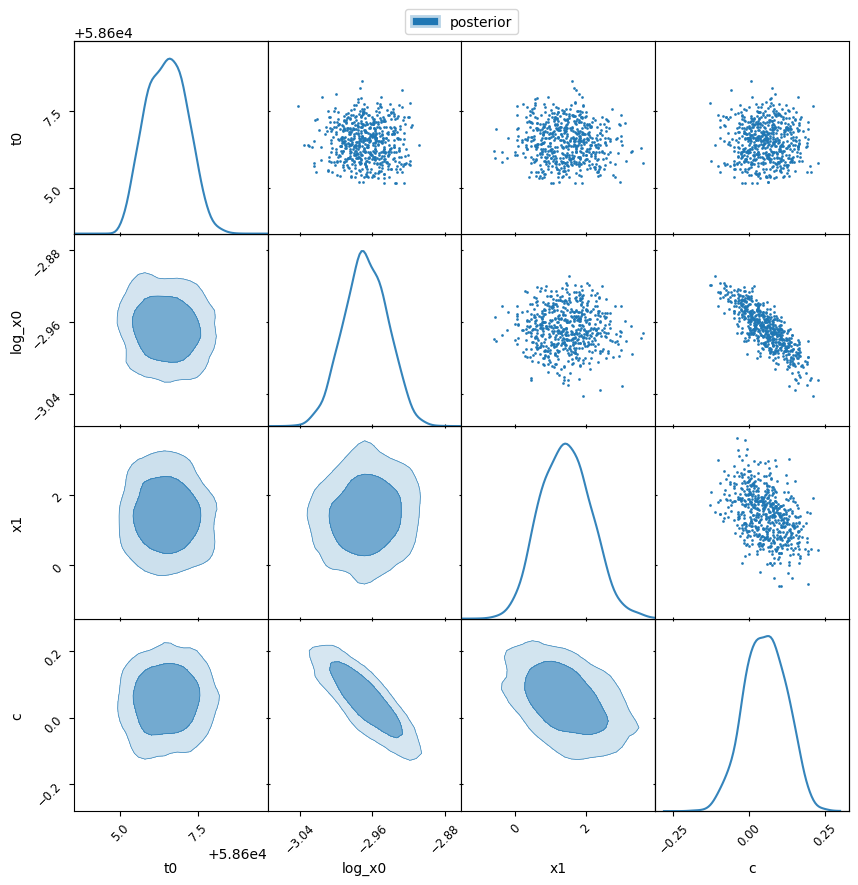

Corner plot saved as 'corner_plot.png'.


In [46]:
# Define parameter names based on whether redshift is fixed or sigma is fit
if fix_z:
    param_names = ['t0', 'log_x0', 'x1', 'c']
else:
    param_names = ['z', 't0', 'log_x0', 'x1', 'c']
if fit_sigma:
    param_names.append('log_sigma')

# Save the chains of dead points
save_chains_dead_birth(dead, param_names)

# Read the chains using anesthetic
samples = read_chains('chains/chains', columns=param_names)

# Create a corner plot of the posterior distributions
fig, axes = make_2d_axes(param_names, figsize=(10, 10), facecolor='w')
samples.plot_2d(axes, alpha=0.9, label="posterior")
axes.iloc[-1, 0].legend(bbox_to_anchor=(len(axes)/2, len(axes)), loc='lower center', ncols=2)

plt.savefig('corner_plot.png')
plt.show()

print("Corner plot saved as 'corner_plot.png'.")

## Parameter Statistics

Finally, we print a summary of the fitted parameters, showing the mean and standard deviation for each parameter based on the posterior samples.

In [47]:
print("\nParameter Statistics:")
print("-" * 50)
for param in param_names:
    mean = samples[param].mean()
    std = samples[param].std()
    print(f"{param}: {mean:.6f} ± {std:.6f}")


Parameter Statistics:
--------------------------------------------------
t0: 58606.500621 ± 0.636398
log_x0: -2.967442 ± 0.023847
x1: 1.440318 ± 0.704653
c: 0.052617 ± 0.067823
